<a href="https://colab.research.google.com/github/AleAlice/TestedeIA/blob/main/Treinando_o_YOLOv5_com_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento personalizado com o YOLOv5

Neste notebook estaremos seguindo alguns passos para treinar o YOLOv5 para reconhecer outros objetos, seguindo esses passos:

* Filtrar imagens para começar o treino
* Exportar para o YOLOv5
* Trainar YOLOv5 para reconhecer os obejetos

#Começe assim:
* crie um custom.yaml na raiz do /content

custom.yaml:

"---

train: /content/yolov5/data/images/train  # Caminho para as imagens de treinamento

val: /content/yolov5/data/images/val  # Caminho para as imagens de validação

nc: 13  # Número de classes

names:

  0: focinho

  1: boca

  2: dentes"

# Passo 1: Clonar Repositório do YOLOv5

In [1]:
#clone YOLOv5 and
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 16767, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 16767 (delta 170), reused 159 (delta 83), pack-reused 16459
Receiving objects: 100% (16767/16767), 15.48 MiB | 15.36 MiB/s, done.
Resolving deltas: 100% (11473/11473), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.0/800.0 kB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 51.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fo

Depois vai em data/images
 e cria duas pastas, uma chamada val e outra chama train
 dentro delas vc coloca as mesmas fotos.


Depois cria uma pasta /content/yolov5/labels
 e crie duas pastas, uma chamada val e outra chama train
 dentro delas vc coloca os txt da seleção.

In [2]:
!wget http://teste-ia.ddns.net:81/zipado.zip -P /content/yolov5/data/images

--2024-07-10 21:28:57--  http://teste-ia.ddns.net:81/zipado.zip
Resolving teste-ia.ddns.net (teste-ia.ddns.net)... 200.203.34.200
Connecting to teste-ia.ddns.net (teste-ia.ddns.net)|200.203.34.200|:81... connected.
HTTP request sent, awaiting response... 200 OK
Length: 718323594 (685M) [application/zip]
Saving to: ‘/content/yolov5/data/images/zipado.zip’

zipado.zip          100%[===================>] 685.05M  10.9MB/s    in 64s     

2024-07-10 21:30:01 (10.7 MB/s) - ‘/content/yolov5/data/images/zipado.zip’ saved [718323594/718323594]



In [3]:
import zipfile
import os

def extract_zip(zip_path, extract_to):
    # Verificar se o arquivo ZIP existe
    if not os.path.isfile(zip_path):
        print(f"O arquivo {zip_path} não existe.")
        return

    # Criar o diretório de extração se não existir
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # Extrair o arquivo ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"Arquivo extraído para {extract_to}")

# Caminho do arquivo ZIP
zip_path = '/content/yolov5/data/images/zipado.zip'

# Diretório onde o arquivo ZIP será extraído
extract_to = '/content/yolov5/data/images/'

# Chamar a função
extract_zip(zip_path, extract_to)


Arquivo extraído para /content/yolov5/data/images/


In [12]:
import os

# Diretórios dos datasets
dataset1_dir = '/content/yolov5/data/images/Teste/Ciclistas/train/labels'
dataset2_dir = '/content/yolov5/data/images/Teste/CSGO/train/labels'
output_dir = '/content/yolov5/data/images/Teste/AAA/train/labels'

# Mapeamento de classes
# Dataset 1 mantém as classes originais: 0, 1, 2, 3
# Dataset 2 renumera: 0 -> 4, 1 -> 5
mapping_dataset2 = {0: 4, 1: 5}

# Função para renumerar as classes
def renumber_classes(input_dir, output_dir, mapping=None):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(input_dir, filename), 'r') as file:
                lines = file.readlines()
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                if mapping:
                    class_id = mapping.get(class_id, class_id)
                new_lines.append(f"{class_id} {' '.join(parts[1:])}\n")
            with open(os.path.join(output_dir, filename), 'w') as file:
                file.writelines(new_lines)

# Renumerar e combinar anotações
renumber_classes(dataset1_dir, output_dir)
renumber_classes(dataset2_dir, output_dir, mapping=mapping_dataset2)


In [11]:
import os
import shutil

# Definir caminhos dos datasets originais
datasets = {
    'CSGO': {
        'train': '/content/yolov5/data/images/Teste/CSGO/train/images',
        'val': '/content/yolov5/data/images/Teste/CSGO/valid/images',
    },
    'Ciclistas': {
        'train': '/content/yolov5/data/images/Teste/Ciclistas/train/images',
        'val': '/content/yolov5/data/images/Teste/Ciclistas/valid/images',
    }
}

# Definir caminhos dos diretórios combinados
combined_paths = {
    'train': '/content/yolov5/data/images/AAA/train/images',
    'val': '/content/yolov5/data/images/AAA/valid/images',
}

# Função para copiar arquivos de um diretório para outro
def copy_files(src_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for filename in os.listdir(src_dir):
        src_file = os.path.join(src_dir, filename)
        dest_file = os.path.join(dest_dir, filename)
        if os.path.isfile(src_file):
            shutil.copy2(src_file, dest_file)
            print(f"Copiado {src_file} para {dest_file}")

# Copiar arquivos de treino
for dataset in datasets.values():
    copy_files(dataset['train'], combined_paths['train'])
    copy_files(dataset['val'], combined_paths['val'])

print("Copiando os arquivos concluído.")

A saída de streaming foi truncada nas últimas 5000 linhas.
Copiado /content/yolov5/data/images/Teste/Ciclistas/train/images/xuujvo141_jpg.rf.e11d882c8198f03b8a800ffc9bca8e16.jpg para /content/yolov5/data/images/AAA/train/images/xuujvo141_jpg.rf.e11d882c8198f03b8a800ffc9bca8e16.jpg
Copiado /content/yolov5/data/images/Teste/Ciclistas/train/images/kbollc189_jpg.rf.36c9258cf9fe46077ede9cf858647480.jpg para /content/yolov5/data/images/AAA/train/images/kbollc189_jpg.rf.36c9258cf9fe46077ede9cf858647480.jpg
Copiado /content/yolov5/data/images/Teste/Ciclistas/train/images/ftkllb249_jpg.rf.0bd8dc8341abbcff28b93222f4c288dd.jpg para /content/yolov5/data/images/AAA/train/images/ftkllb249_jpg.rf.0bd8dc8341abbcff28b93222f4c288dd.jpg
Copiado /content/yolov5/data/images/Teste/Ciclistas/train/images/wblqxk9_jpg.rf.43a2905913d603cf460b3ddfe74c32b2.jpg para /content/yolov5/data/images/AAA/train/images/wblqxk9_jpg.rf.43a2905913d603cf460b3ddfe74c32b2.jpg
Copiado /content/yolov5/data/images/Teste/Ciclistas/t

# Step 3: Train Our Custom YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training

In [ ]:
!python train.py --img 512 --batch 16 --epochs 50 --data /content/data.yaml --weights yolov5s.pt --cache

2024-07-10 21:54:08.497554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 21:54:08.497660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 21:54:08.643922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=Fals

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

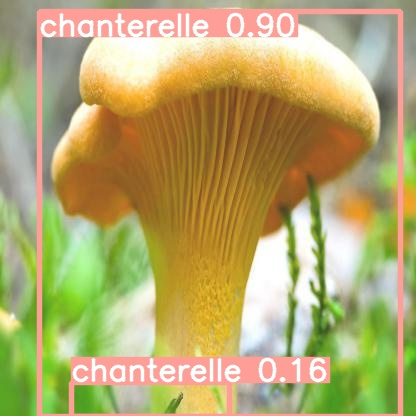

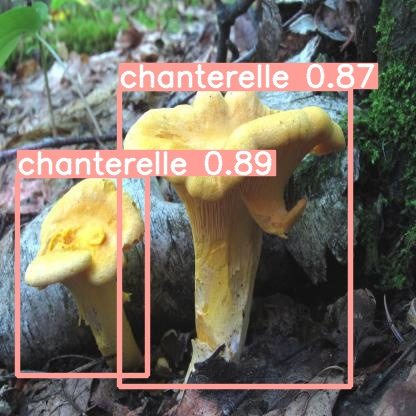

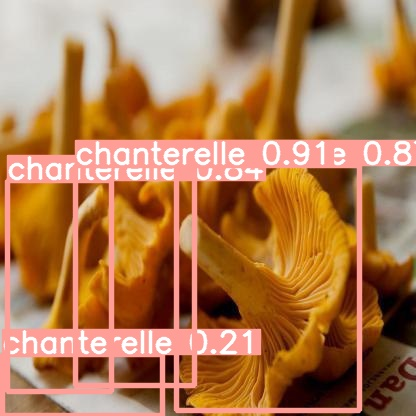

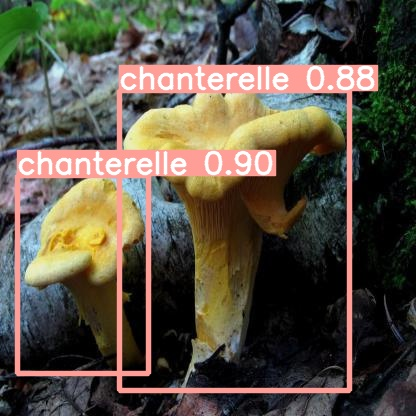

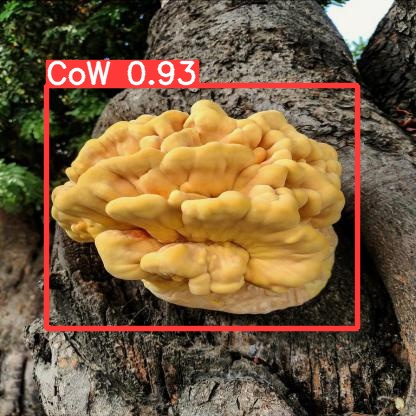

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Conclusion and Next Steps

Congratulations! You've trained a custom YOLOv5 model to recognize your custom objects.

To improve you model's performance, we recommend first interating on your datasets coverage and quality. See this guide for [model performance improvement](https://github.com/ultralytics/yolov5/wiki/Tips-for-Best-Training-Results).

To deploy your model to an application, see this guide on [exporting your model to deployment destinations](https://github.com/ultralytics/yolov5/issues/251).

Once your model is in production, you will want to continually iterate and improve on your dataset and model via [active learning](https://blog.roboflow.com/what-is-active-learning/).

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>